In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

Import useful libraries, read in the dataset, and display some of them.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(r'./players_20.csv')
df['count'] = 1  #Assit col
df = df[df['value_eur'] > 1]  #Exclude player with 0 value
df.head(5)

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,count
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,...,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2,1
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,...,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,1
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,...,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3,1
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,...,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3,1


In [126]:
df['best_pos'] = df['player_positions'].str.split(',').str[0]
df_player = df[df['best_pos']!= 'GK'].copy()

dct_pos = {
    'ST': 'Fwd_Centre',
    'CF': 'Fwd_Centre',
    'LW': 'Fwd_Winger',
    'RW': 'Fwd_Winger',
    'CM': 'Mid_Centre',
    'CAM': 'Mid_Centre',
    'CDM': 'Mid_Centre',
    'LM': 'Mid_Side',
    'RM': 'Mid_Side',
    'CB': 'Back_Centre',
    'LB': 'Back_Side',
    'RB': 'Back_Side',
    'LWB': 'Back_Winger',
    'RWB': 'Back_Winger',
}

df_player['best_pos'] = df_player['best_pos'].map(dct_pos)

s = ['Back_Centre',
 'Back_Side',
 'Back_Winger',
 'Mid_Centre',
 'Mid_Side',
 'Fwd_Centre',
 'Fwd_Winger']

### Given the 6 basic attributes, can we derive the player's best position?

This would be a classification problem, and it can be tackled by a number of techniques. We will try:
1. k-Nearest Neighbors
2. Classification tree
3. Neural Network Classifier

First, we will normalize these attributes by the footballer's overall score. This is to find the relative strength of the player rather than comparing the absolute strength between players.
Second, we will fit the data and attempt to predict the best position for each player given thei relative strength, and presented using a confusion matrix.

C:\Users\edhz8\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Text(0.5, 1.0, 'MLP Classifier / F-score0.8085438104147178')

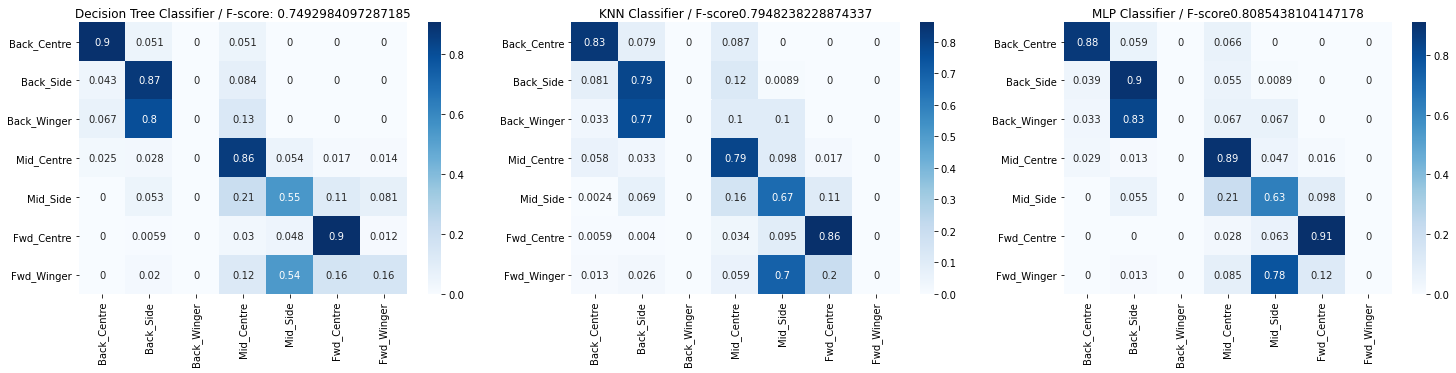

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
    
cols = ['attacking_crossing','attacking_finishing','attacking_heading_accuracy',
        'attacking_short_passing','attacking_volleys','skill_dribbling','skill_curve',
        'skill_fk_accuracy','skill_long_passing','skill_ball_control','movement_acceleration',
        'movement_sprint_speed','movement_agility','movement_reactions','movement_balance',
        'power_shot_power','power_jumping','power_stamina','power_strength','power_long_shots',
        'mentality_aggression','mentality_interceptions','mentality_positioning','mentality_vision',
        'mentality_penalties','mentality_composure','defending_marking','defending_standing_tackle',
        'defending_sliding_tackle']

def display_confusion_matrix(y, y_hat, label, axs):
    res = confusion_matrix(y, y_hat, labels = label)
    row_sums = res.astype(np.float).sum(axis=1)
    res = res/row_sums[:, np.newaxis]
    res = pd.DataFrame(res, columns = label, index = label)
    sns.heatmap(res, cmap="Blues", annot=True, ax=axs)

for col in cols:
    df_player['n_'+col] = df_player[col] / df_player['overall']

req_col_detail = ['n_'+col for col in cols]

X = df_player[req_col_detail]
y = df_player['best_pos']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

fig, ax = plt.subplots(ncols=3, figsize=(25,5))

#Decision Tree Classifier

model = tree.DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train)
t_pred=model.predict(X_test)
display_confusion_matrix(y_test, t_pred, s, ax[1])

#KNN Classifier
classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(X_train, y_train)
k_pred = classifier.predict(X_test)
display_confusion_matrix(y_test, k_pred, s, ax[0])



#Neural Net Classifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(7,7,7), activation='relu',random_state=1)
clf.fit(X_train, y_train)
m_pred = clf.predict(X_test)
display_confusion_matrix(y_test,m_pred , s, ax[2])

ax[0].set_title('Decision Tree Classifier / F-score: '+str(f1_score(y_test, t_pred,average='micro')))
ax[1].set_title('KNN Classifier / F-score'+str(f1_score(y_test, k_pred,average='micro')))
ax[2].set_title('MLP Classifier / F-score'+str(f1_score(y_test, m_pred,average='micro')))

In [70]:
MLP_result = list(zip(mlp_acc,layer_list))
MLP_result.sort(reverse=True)
for i,j in MLP_result:
     print("정확도: ", i, "/ 은닉층: ",j)

정확도:  0.8048019956345495 / 은닉층:  [10, 10, 10, 10, 10, 10, 10, 10, 10]
정확도:  0.8029310882444652 / 은닉층:  [10]
정확도:  0.8013719987527284 / 은닉층:  [9, 9]
정확도:  0.801060180854381 / 은닉층:  [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
정확도:  0.8007483629560337 / 은닉층:  [10, 10, 10, 10, 10, 10, 10]
정확도:  0.8007483629560337 / 은닉층:  [6, 6, 6, 6, 6]
정확도:  0.8001247271593389 / 은닉층:  [10, 10, 10, 10, 10]
정확도:  0.8001247271593389 / 은닉층:  [9, 9, 9, 9]
정확도:  0.7998129092609916 / 은닉층:  [9, 9, 9, 9, 9, 9, 9, 9, 9]
정확도:  0.7995010913626442 / 은닉층:  [6, 6, 6]
정확도:  0.7995010913626442 / 은닉층:  [6]
정확도:  0.7988774555659495 / 은닉층:  [9, 9, 9, 9, 9, 9]
정확도:  0.7988774555659495 / 은닉층:  [6, 6, 6, 6]
정확도:  0.7985656376676021 / 은닉층:  [9]
정확도:  0.7985656376676021 / 은닉층:  [8]
정확도:  0.7985656376676021 / 은닉층:  [5, 5, 5, 5]
정확도:  0.7979420018709074 / 은닉층:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
정확도:  0.7979420018709074 / 은닉층:  [7, 7, 7, 7, 7, 7, 7, 7, 7]
정확도:  0.7973183660742127 / 은닉층:  [10, 10, 10, 10]
정확도:  0.7973183660742127 / 은닉층:  [

Text(0.5, 1.0, 'Accuracy according to layer of count of layer')

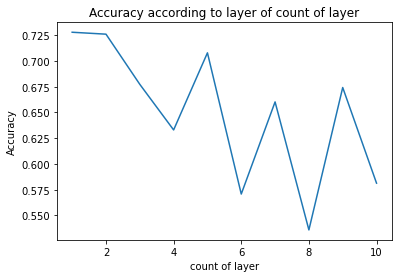

In [72]:
avg_acc_layer=[]
for i in range(0,10): avg_acc_layer.append(np.mean([mlp_acc[j+i] for j in range(0,91,10)]))
plt.plot(range(1,11),avg_acc_layer)
plt.xlabel("count of layer")
plt.ylabel("Accuracy")
plt.title("Accuracy according to layer of count of layer")
# zip_count_of_layer=list(zip(avg_acc_layer,range(1,11)))
# zip_count_of_layer.sort(reverse=True)
# print(zip_count_of_layer)

        

[(0.7967882756470221, 10), (0.7956345494231369, 7), (0.7954162768942937, 9), (0.7452447770502026, 8), (0.739413782351107, 6), (0.6845961958216401, 4), (0.681789834736514, 5), (0.5201122544434051, 3), (0.4434674150296227, 2), (0.29186155285313375, 1)]


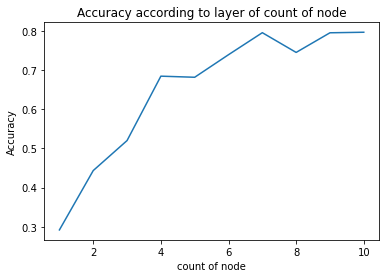

In [68]:
avg_acc_node=[]
for i in range(0,10): avg_acc_node.append(np.mean(mlp_acc[i*10:i*10+10]))
plt.plot(range(1,11),avg_acc_node)
plt.xlabel("count of node")
plt.ylabel("Accuracy")
plt.title("Accuracy according to layer of count of node")
zip_count_of_node=list(zip(avg_acc_node,range(1,11)))
zip_count_of_node.sort(reverse=True)
print(zip_count_of_node)

Text(0.5, 1.0, 'Accuracy according to count of layers')

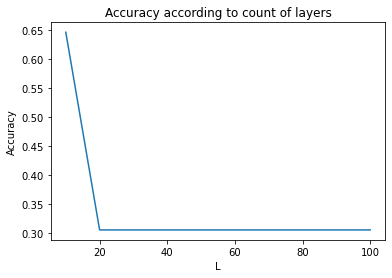

In [122]:
mlp_acc2=[]
layer_list2=[[i]*j for i in range(10,11) for j in range(10,101,10)]
for L in range(len(layer_list2)):
    clf = MLPClassifier(solver='adam',hidden_layer_sizes=layer_list[L], activation='relu',max_iter=1000)
    clf.fit(X_train, y_train)
    mlp_acc2.append(clf.score(X_test,y_test))

plt.plot([10,20,30,40,50,60,70,80,90,100],mlp_acc2)
plt.xlabel("L")
plt.ylabel("Accuracy")
plt.title("Accuracy according to count of layers")

In [46]:
MLP_result2 = list(zip(mlp_acc2,layer_list2))
MLP_result2.sort(reverse=True)
for i,j in MLP_result2:
    print("정확도: ", i, "/ 은닉층: ",j)

정확도:  0.6423448705955722 / 은닉층:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
정확도:  0.6382912379170564 / 은닉층:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
정확도:  0.6373557842220143 / 은닉층:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
정확도:  0.29186155285313375 / 은닉층:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
정확도:  0.29186155285313375 / 은닉층:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

Text(0.5, 1.0, 'Accuracy according to count of node')

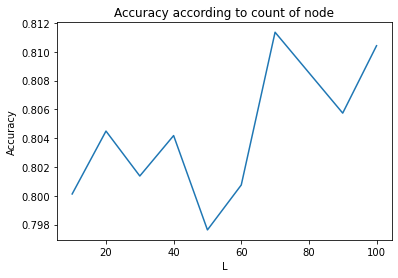

In [73]:
mlp_acc3=[]
layer_list3=[[i]*j for i in range(10,101,10) for j in range(2,3)]
for L in range(len(layer_list2)):
    clf = MLPClassifier(solver='adam',hidden_layer_sizes=layer_list3[L], activation='relu',max_iter=1000)
    clf.fit(X_train, y_train)
    mlp_acc3.append(clf.score(X_test,y_test))

plt.plot(range(10,101,10),mlp_acc3)
plt.xlabel("L")
plt.ylabel("Accuracy")
plt.title("Accuracy according to count of node")

In [79]:
mlp_acc_final=[]
zip_ij=[(i,j) for i in range(70,101) for j in [2,3,4,5,10,15,20,25,30]]
layer_list_final=[[i]*j for i,j in zip_ij]
for L in range(len(layer_list_final)):
    clf = MLPClassifier(solver='adam',hidden_layer_sizes=layer_list_final[L], activation='relu',max_iter=1000)
    clf.fit(X_train, y_train)
    mlp_acc_final.append(clf.score(X_test,y_test))

Text(0.5, 1.0, 'Accuracy according to Count of Node and Layer')

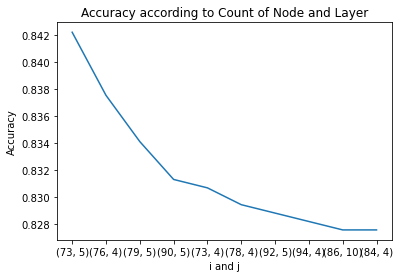

In [86]:
# plt.plot(range(1,len(zip_ij)+1),mlp_acc_final)
# plt.xlabel("i and j")
# plt.ylabel("Accuracy")
# plt.title("Accuracy according to Layers")

# result = list(zip(mlp_acc_final,zip_ij))
# result.sort(reverse=True)
# for i,j in result:
#     print("(노드의 갯수,은닉층의 수):",j,"/ 정확도:",i)
plt.plot(["(73, 5)",'(76, 4)','(79, 5)','(90, 5)','(73, 4)','(78, 4)','(92, 5)','(94, 4)','(86, 10)','(84, 4)'],sorted(mlp_acc_final,reverse=True)[:10])
plt.xlabel("i and j")
plt.ylabel("Accuracy")
plt.title("Accuracy according to Count of Node and Layer")